In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as so
import pandas as pd
import numpy as np

def simpleRegPredict(b,x):
    """Prediction function for simple regression
    Args:
        b (array): 2 element array with intercept and slope
        x (array): array of x values
    Returns:
        yp (array): array of predicted y valuess
    """
    yp=b[0]+b[1]*x
    return yp

def simpleRegLossRSS(b,x,y):
    """Simple residual sums of squares loss functions
    Args:
        b (array): 2 element array with intercept and slope
        x (array): array of x values
        y (array): array of y values

    Returns:
        rss (float): Residual sums of squares
        deriv (array): array of derivatives of the loss function with respect to b
    """
    predY = simpleRegPredict(b,x)
    res = y-predY
    rss = sum(res**2)
    deriv = np.zeros(2)
    deriv[0]=-2*sum(res)
    deriv[1]=-2*sum(res*x)
    return (rss,deriv)

def plotPrediction(b,x,y,predfcn):
    """Plot the prediction of a simple regression
    Args:
        b (array): array of parameter values
        x (array): array of x values
        y (array): array of y values
        predfcn (function): prediction function
    """
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x,y)
    xp = np.linspace(min(x),max(x),num=50)
    yp = predfcn(b,xp)
    ax.plot(xp,yp,'r')

def simpleRegFit(x,y,lossFcn=simpleRegLossRSS):
    """Perform simple regression fit with a loss function
    Args:
        x (array): array of x values
        y (array): array of y values
        lossFcn (function): Loss function Defaults to simpleRegLossRSS.

    Returns:
        R2 (float): Coefficient of determination
        b (array): array of fitted parameter values
    """
    b0=[np.mean(y),0]
    RES = so.minimize(lossFcn,b0,args=(x,y),jac=True)
    b=RES.x # Results
    plotPrediction(b,x,y,simpleRegPredict)
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,grad = simpleRegLossRSS(b,x,y)
    R2 = 1-RSS/TSS
    return (R2,b)

def addPrediction(b,x,predFunc,ax,linestyle='r:'):
    """Add a prediction to a plot
    Args:
        b (array): array of parameter values
        x (array): array of x values
        predFunc (function): prediction function
        ax (axis): axis to plot on
        linestyle (string): linestyle for the plot
    """
    xrange = max(x)-min(x)
    xp = np.linspace(min(x)-xrange/30,max(x)+xrange/30,num=50)
    yp = predFunc(b,xp)
    ax.plot(xp,yp,linestyle)
    return(ax)

def multRegPredict(b,D,xname):
    """Model prediction function for multiple regression

    Args:
        b (array): Q+1 regression coefficients for Q variables
        D (pd.DataFrame): Data frame
        xname (list): Names of explanatory variables

    Returns:
        yp (array): predicted y-values
    """
    yp=np.ones(len(D.index))*b[0]        # Intercept
    for i in range(len(xname)):
        yp=yp+D[xname[i]]*b[i+1]         # Add each regression value
    return yp

def multRegLossRSS(b,D,y,xname):
    """Residual sums of squares loss function for multiple regression
    Args:
        b (array): Q+1 regression coefficients for Q variables
        D (pd.DataFrame): Data frame
        xname (list): Names of explanatory variables

    Returns:
        rss (float): Residual sums of squares
        deriv (array): array of derivatives of the loss function with respect to b
    """
    predY = multRegPredict(b,D,xname)
    res = y-predY
    rss = sum(res**2)
    grad=np.zeros(len(b))
    grad[0]=-2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1]=-2*np.sum(D[xname[i]]*res)
    return (rss,grad)

def multRegFit(D,y,xname):
    """Multiple regression fitting function
    Args:
        D (pd.DataFrame): Data frame
        y (array): array of y values
        xname (list): Names of explanatory variables

    Returns:
        R2 (float): Coefficient of determination
        b (array): array of fitted parameter values
    """
    N=len(xname)
    b0=np.zeros((N+1,))
    RES = so.minimize(multRegLossRSS,b0,args=(D,y,xname),
                    jac=True,
                    tol=1e-3)
    if (not(RES.success)):
        print('unsuccessful fit')
        print(RES)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,deriv = multRegLossRSS(b,D,y,xname)
    R2 = 1-RSS/TSS
    return (R2,b)

def bootstrapReg(D,y,args,fitfcn,numIter=1000):
    """Bootstrap for regression

    Args:
        D (pd.DataFrame): Data frame with explanatory variables
        y (array): array of y values
        args (tuple): additional arguments for the fit function
        fitfcn (function): fit function
        numIter (int, optional): Number of bootstrap samples. Defaults to 1000.

    Returns:
        stats(array): 2-D array of parameter values
    """
    r2,b=fitfcn(D,y,args)
    numParams=len(b)
    N = len(D.index)
    ind  = np.arange(N)
    stats = np.zeros((numIter,numParams))
    for i in range(numIter):
        sample=np.random.choice(ind,N)
        r2,stats[i,:]=fitfcn(D.iloc[sample],y[sample],args)
    return stats

def confidenceInt(data,perc):
    """Confidence interval for data from percentiles method
    Args:
        data (array): _description_
        perc (Percent within confidence interval): percent within confidence interval
    Returns:
        int (tuple): tuple with lower and upper bounds of confidence interval
    """
    Int=(np.percentile(data,(100-perc)/2),np.percentile(data,100-(100-perc)/2))
    return Int

In [2]:
df = pd.read_csv('covid19_by_country.csv')

In [18]:
nan_proportion = sum(df['Tests'].isna()) / len(df['Tests'])

print(f"Proportion of NaN values: {nan_proportion:.2%}")

df['InfectionRate'] = (df['TotalInfected'] / df['Population2020'])


Proportion of NaN values: 51.04%


(array([[88.,  5.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
        [93.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([1.20000000e+01, 1.43943178e+05, 2.87874355e+05, 4.31805533e+05,
        5.75736710e+05, 7.19667888e+05, 8.63599066e+05, 1.00753024e+06,
        1.15146142e+06, 1.29539260e+06, 1.43932378e+06]),
 <a list of 2 BarContainer objects>)

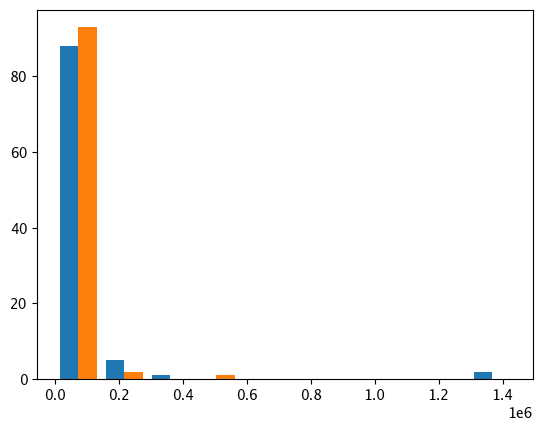

In [13]:

plt.hist([df['Population2020'], df['TotalInfected']])


Predicted infection rate for 20% urban population: -0.257


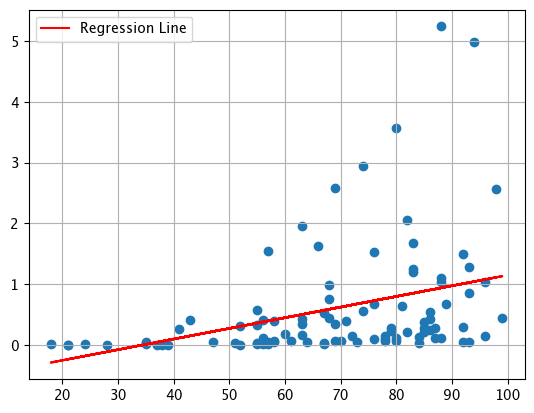

In [21]:
x = df['UrbanPop']
y = df['InfectionRate']

# Fit the model
R2, b = simpleRegFit(x, y)

# Calculate predicted value for urbanPop = 20%
predicted_value = b[0] + b[1] * 20

print(f"\nPredicted infection rate for 20% urban population: {predicted_value:.3f}")

# Add regression line to plot
plt.plot(x, b[0] + b[1]*x, 'r-', label='Regression Line')
plt.legend()
plt.grid(True)

R² for simple regression: 0.126
R² for multiple regression: 0.319
Increase in R²: 0.193


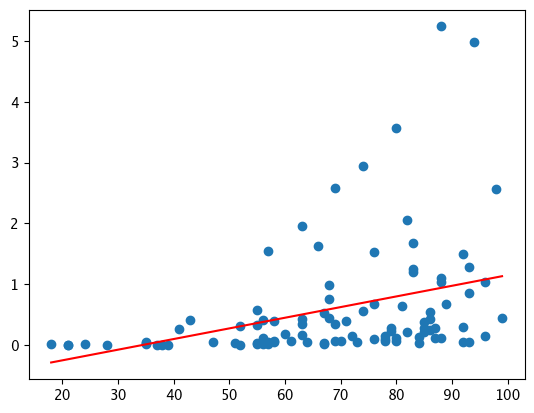

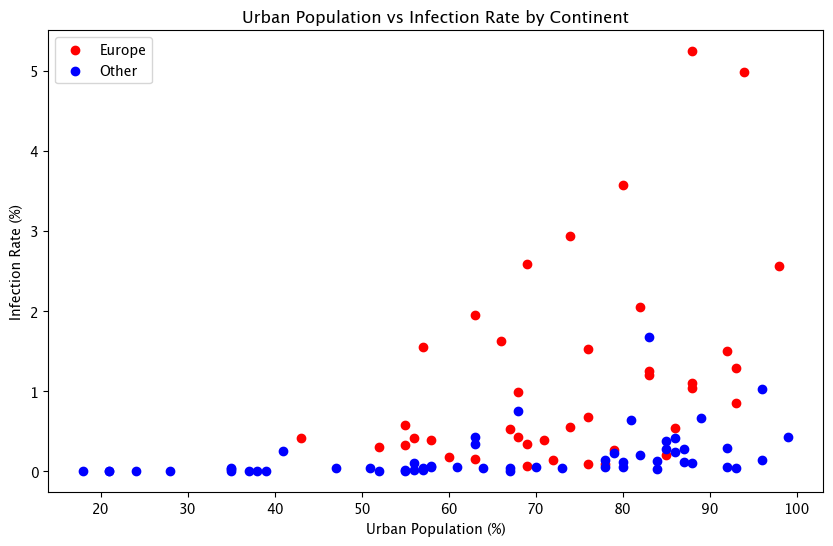

In [22]:
# First create indicator variable for European countries
df['IsEurope'] = (df['Continent'] == 'Europe').astype(int)

# Fit simple regression (from previous question)
x_simple = df['UrbanPop']
y = df['InfectionRate']
R2_simple, b_simple = simpleRegFit(x_simple, y)

# Fit multiple regression with Europe indicator
R2_multiple, b_multiple = multRegFit(df, df['InfectionRate'], ['UrbanPop', 'IsEurope'])

# Calculate the increase in R²
R2_increase = R2_multiple - R2_simple

print(f"R² for simple regression: {R2_simple:.3f}")
print(f"R² for multiple regression: {R2_multiple:.3f}")
print(f"Increase in R²: {R2_increase:.3f}")

# Visualize the difference
plt.figure(figsize=(10, 6))
plt.scatter(df[df['IsEurope']==1]['UrbanPop'], df[df['IsEurope']==1]['InfectionRate'], 
           label='Europe', color='red')
plt.scatter(df[df['IsEurope']==0]['UrbanPop'], df[df['IsEurope']==0]['InfectionRate'], 
           label='Other', color='blue')
plt.xlabel('Urban Population (%)')
plt.ylabel('Infection Rate (%)')
plt.title('Urban Population vs Infection Rate by Continent')
plt.legend()

Predicted Infection Rate for UrbanPop = 50: 0.223


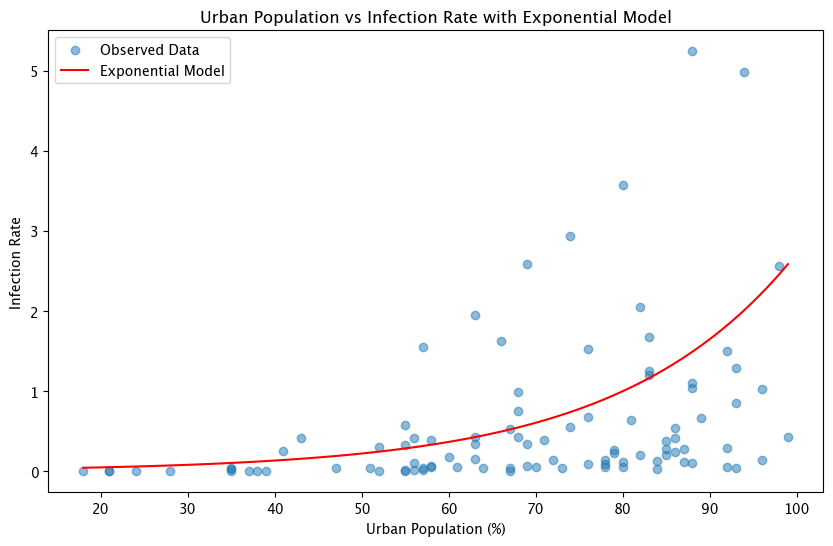

In [23]:
def expRegPredict(b, D, xname):
    """Exponential regression prediction function
    Args:
        b (array): regression coefficients [b0, b1]
        D (pd.DataFrame): Data frame with explanatory variables
        xname (list): Names of explanatory variables
    Returns:
        yp (array): predicted y-values
    """
    yp = np.exp(b[0] + b[1]*D[xname[0]])
    return yp

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['UrbanPop'], df['InfectionRate'], alpha=0.5, label='Observed Data')

# Generate prediction line using given coefficients
x_range = np.linspace(min(df['UrbanPop']), max(df['UrbanPop']), 100)
b = [-4, 0.05]  # given coefficients
pred_y = expRegPredict(b, pd.DataFrame({'UrbanPop': x_range}), ['UrbanPop'])

# Add prediction line to plot
plt.plot(x_range, pred_y, 'r-', label='Exponential Model')
plt.xlabel('Urban Population (%)')
plt.ylabel('Infection Rate')
plt.title('Urban Population vs Infection Rate with Exponential Model')
plt.legend()

# Calculate predicted value for UrbanPop = 50
pred_50 = expRegPredict(b, pd.DataFrame({'UrbanPop': [50]}), ['UrbanPop'])[0]
print(f"Predicted Infection Rate for UrbanPop = 50: {pred_50:.3f}")

Intercept (b0): -3.055


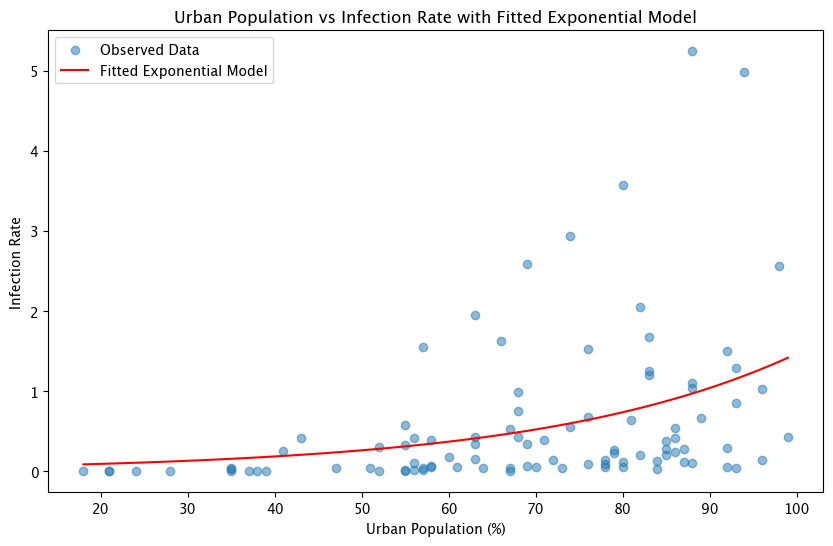

In [26]:
def expRegLoss(b, D, y, xname):
    """
    Exponential regression loss function
    Args:
        b (array): regression coefficients [b0, b1]
        D (pd.DataFrame): Data frame with explanatory variables
        y (array): observed y-values
        xname (list): Names of explanatory variables
    Returns:
        L (float): Loss value
    """
    # Get predictions using our exponential predict function
    yp = expRegPredict(b, D, xname)
    
    # Calculate sum of squared residuals
    L = np.sum((y - yp)**2)
    
    return L

# Initial guess for parameters
b0 = [0, 0]  # starting with [0,0] as initial guess

# Prepare data
X = df[['UrbanPop']]
y = df['InfectionRate']

# Minimize the loss function
result = so.minimize(expRegLoss, 
                    b0, 
                    args=(X, y, ['UrbanPop']),
                    method='BFGS',
                    jac=False,
                    tol=1e-4)

# Get the optimal parameters
b_opt = result.x

print(f"Intercept (b0): {b_opt[0]:.3f}")

# Plot the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(df['UrbanPop'], df['InfectionRate'], alpha=0.5, label='Observed Data')

# Generate prediction line using fitted coefficients
x_range = np.linspace(min(df['UrbanPop']), max(df['UrbanPop']), 100)
pred_y = expRegPredict(b_opt, pd.DataFrame({'UrbanPop': x_range}), ['UrbanPop'])

plt.plot(x_range, pred_y, 'r-', label='Fitted Exponential Model')
plt.xlabel('Urban Population (%)')
plt.ylabel('Infection Rate')
plt.title('Urban Population vs Infection Rate with Fitted Exponential Model')
plt.legend()